In [1]:
import numpy as np
import tulipy as ti
import pandas_datareader.data as web
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf
import math as m
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn import svm

In [2]:
style.use('ggplot')
# Date information
start_date = datetime.datetime(2015,1,1)
end_date = datetime.datetime(2022,1,3)
# Stock symbols
stock_symbols = pd.read_csv("tickers.csv", names = ["symbols"])
current_stock = stock_symbols.symbols[10]
print(current_stock)
# High Low Open Close data about the stock chosen
data = web.DataReader(current_stock, "yahoo", start_date, end_date)

ABB


In [3]:
def np_attributes(df):
    """
    Changed each column to numpy arrays
    [ high, low, close, volume, open]
    """
    close = df.Close.to_numpy()
    volume = df.Volume.to_numpy()
    high = df.High.to_numpy()
    low = df.Low.to_numpy()
    Open = df.Open.to_numpy()
    return [high,low, close, volume, Open]

In [4]:
def simple_moving_average(df, period):
    """
    DOES CHANGE SIZE MAKES NEW DF
    df - pandas dataframe
    period - how much the moving average is measured on
    return -  dataframe with simple moving average in it
    """
    np_vals = np_attributes(df)
    changed_df = df
    sma = ti.sma(np_vals[2], period)
    changed_df = changed_df.drop(changed_df.index[0:period-1])        
    changed_df["SMA"] = sma
    return changed_df

def accumulation_line(df, high, low, close, volume):
    """
    DOES NOT CHANGE SIZE ADDS TO GIVEN DF
    numpy arrays with the respective values and a
    pandas dataframe
    return - the dataframe with the accumulation line
    """
    ad = ti.ad(high, low, close, volume)
    df["AC Line"] = ad
    return df

def target_column(df, threshold, period):
    """DOES CHANGE SIZE OF DATAFRAME
        Makes target labels of 0 and 1
        depending on the threshold and period. 
        Both the threshold and period are ints
        
        Returns - the dataframe given (now smaller)
        with the target column in it
    """
    target = []
    profits = []
    i = 0
    while i<df.Close.shape[0]:
        if i+period >= df.Close.shape[0]:
            break
        profit =(df.Close[i]-df.Close[i+period])/df.Close[i]
        if profit<0:
            target.append(0)
            profits.append(profit)
        else:
            target.append(1)
            profits.append(profit)
        i+=1
    df = df.drop(df.index[0:period])
    df["Target"] = target
    return df

def fishers_transform(df, high, low, period = 0):
    """ CHANGES SIZE 
        INPUT - HIGH LOW, PERIOD
        OUTPUT - fisher_transfrom and its singal in the
        given dataframe
    
    """
    changed_df = df
    fisher,fisher_signal = ti.fisher(high, low, period)
    changed_df = changed_df.drop(changed_df.index[0:period-1])
    changed_df["fisher"] = fisher
    changed_df["fisher signal"] = fisher_signal
    return changed_df

def balance_of_power(df, high, low, Open, close):
    """Does not change size"""
    
    balance = ti.bop(Open, high, low, close)
    df["BalanceOP"] = balance
    return df
    

In [5]:
data = simple_moving_average(data,100)
attri =np_attributes(data)
data = accumulation_line(data, attri[0], attri[1],attri[2],attri[3])
data = fishers_transform(data,attri[0],attri[1], 5)
attri =np_attributes(data)
data = balance_of_power(data,attri[0], attri[1], attri[4], attri[2])
df = target_column(data, 0.05, 4)
print(df)

                 High        Low       Open      Close     Volume  Adj Close  \
Date                                                                           
2015-06-05  23.139999  22.549999  23.139999  22.799999  3635400.0  18.118155   
2015-06-08  22.750000  22.590000  22.660000  22.670000  1578300.0  18.014853   
2015-06-09  22.760000  22.610001  22.709999  22.610001  1183600.0  17.967171   
2015-06-10  23.059999  22.879999  22.920000  22.940001  1464700.0  18.229410   
2015-06-11  22.760000  22.559999  22.740000  22.700001  1275500.0  18.038692   
...               ...        ...        ...        ...        ...        ...   
2021-12-28  38.459999  38.270000  38.320000  38.380001   802400.0  38.380001   
2021-12-29  38.660000  38.320000  38.320000  38.650002   907000.0  38.650002   
2021-12-30  38.509998  38.090000  38.410000  38.139999  1370600.0  38.139999   
2021-12-31  38.349998  38.110001  38.110001  38.169998   706900.0  38.169998   
2022-01-03  38.660000  38.259998  38.619

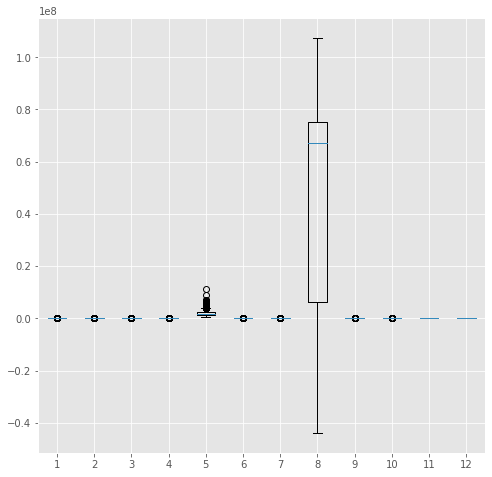

In [6]:
# looking at the data before any operations are made
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(1,1,1)
ax.boxplot(df);

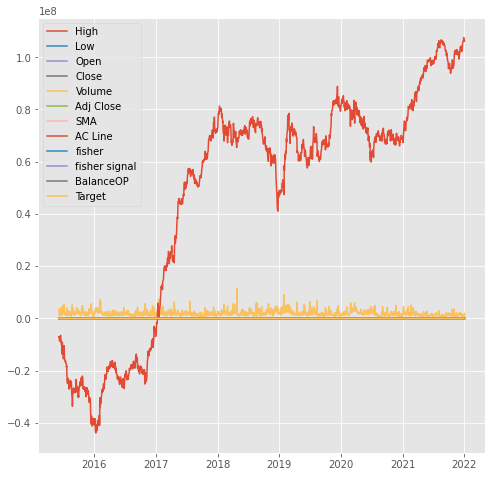

In [7]:
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(1,1,1)
ax.plot(df)
ax.legend(df.columns);

In [8]:
x = df.loc[:, ["High","Low", "Close", "Volume", "SMA", "AC Line", "fisher", "fisher signal",
              "BalanceOP"]]
y = df.loc[:, ['Target']]

# normalising manually
x = x.to_numpy()
mu = np.mean(x, 0)
sigma = np.std(x, 0)
x = (x - mu) / sigma

y = y.to_numpy()

x_train = x[0:m.floor(x.shape[0] * 0.9)]
y_train = y[0:m.floor(y.shape[0]*0.9)]
x_test = x[m.ceil(x.shape[0] * 0.9):x.shape[0]]
y_test = y[m.ceil(y.shape[0] * 0.9):y.shape[0]]

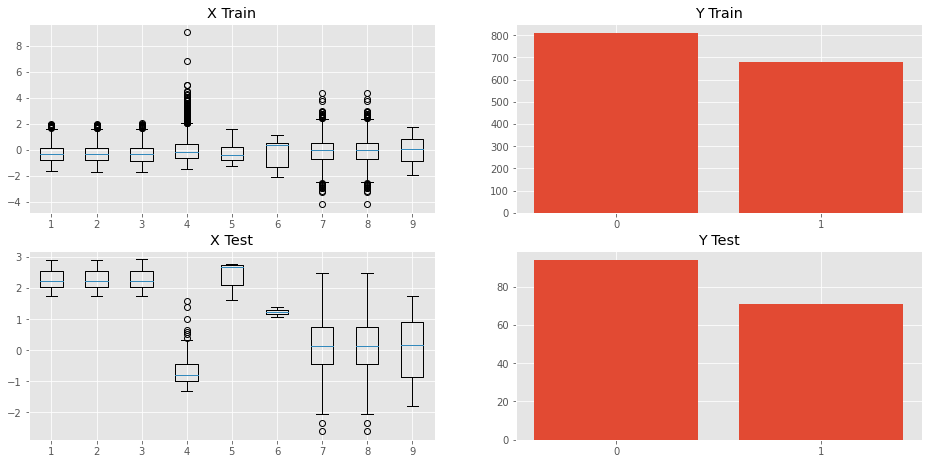

In [9]:
fig = plt.figure(figsize=[16,16])
ax = fig.add_subplot(4,2,1)
ax.boxplot(x_train)
ax.set_title("X Train");

ax = fig.add_subplot(4,2,2)
(u, c) = np.unique(y_train, return_counts=True)
ax.bar(u, c)
ax.set_xticks(u)
ax.set_title("Y Train");

ax = fig.add_subplot(4,2,3)
ax.boxplot(x_test)
ax.set_title("X Test");

ax = fig.add_subplot(4,2,4)
(u, c) = np.unique(y_test, return_counts=True)
ax.bar(u, c)
ax.set_xticks(u)
ax.set_title("Y Test");

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(1,9)))
model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))

In [11]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 512)            5120      
_________________________________________________________________
dropout (Dropout)            (None, 1, 512)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 256)            131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 128)            32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1, 64)             8

In [12]:
adam = model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
his = model.fit(x_train, y_train, epochs=30, validation_data = (x_test,y_test))

Epoch 1/30
47/47 [==============================] - 1s 6ms/step - loss: 0.5291 - accuracy: 0.7366 - val_loss: 0.4603 - val_accuracy: 0.7394
Epoch 2/30
47/47 [==============================] - 0s 4ms/step - loss: 0.3331 - accuracy: 0.8479 - val_loss: 0.6842 - val_accuracy: 0.7152
Epoch 3/30
47/47 [==============================] - 0s 4ms/step - loss: 0.2583 - accuracy: 0.8901 - val_loss: 0.4959 - val_accuracy: 0.8303
Epoch 4/30
47/47 [==============================] - 0s 4ms/step - loss: 0.2511 - accuracy: 0.8887 - val_loss: 0.9013 - val_accuracy: 0.6909
Epoch 5/30
47/47 [==============================] - 0s 4ms/step - loss: 0.2407 - accuracy: 0.9048 - val_loss: 0.3148 - val_accuracy: 0.9030
Epoch 6/30
47/47 [==============================] - 0s 4ms/step - loss: 0.2287 - accuracy: 0.9015 - val_loss: 0.3971 - val_accuracy: 0.8303
Epoch 7/30
47/47 [==============================] - 0s 4ms/step - loss: 0.2186 - accuracy: 0.9115 - val_loss: 0.2712 - val_accuracy: 0.9091
Epoch 8/30
47/47 [==

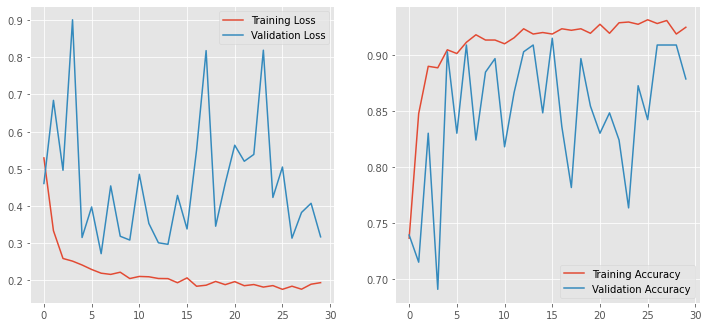

In [13]:
fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(2,2,1)
ax.plot(his.history["loss"], label="Training Loss")
ax.plot(his.history["val_loss"], label="Validation Loss")
ax.legend();

ax = fig.add_subplot(2,2,2)
ax.plot(his.history["accuracy"], label="Training Accuracy")
ax.plot(his.history["val_accuracy"], label="Validation Accuracy")
ax.legend();

# Have fun
Didn't look at your K-NN stuff

In [ ]:
# K nearest Neighbours
n=1
best_n = 1
best_acc = 0
while n<50:
    knn_model = KNeighborsClassifier(n_neighbors = n)
    knn_model.fit(x_train, y_train)
    predictions = knn_model.predict(x_test)
    i = 0
    total = 0
    correct = 0
    cor = []
    inc = []
    tot = []
    while i<len(predictions):
        if (predictions[i] == y_test[i] and predictions[i] == 1):
            total+=1
            correct+=1
            cor.append(y_test[i])
        elif predictions[i] == 1 and y_test[i]!= 1:
            total+=1
            inc.append(y_test[i])
        elif y_test[i] == 1:
            tot.append(y_test[i])
            total+=1
        i+=1
        
    if len(cor) == 0 or len(tot)==0:
        continue        
    else:
        acc = len(cor)/len(tot)
    if best_n == 1:
        best_n = n
        best_acc = acc
    elif best_acc < acc:
        best_acc = acc            
        best_n = n
    n+=1
print(best_acc, best_n)

In [ ]:
parameters = {"weights": ["uniform", "distance"]}
gridsearch = GridSearchCV(KNeighborsClassifier(n_neighbors = best_n), parameters)
gridsearch.fit(x_train, y_train)
predictions = gridsearch.predict(x_test)

In [121]:
i = 0
total = 0
correct = 0
cor = []
inc = []
tot = []
    
while i<len(predictions):
    if (predictions[i] == y_test[i] and predictions[i] == 1):
            #print ((predictions[i], y_test[i]))
        total+=1
        correct+=1
        cor.append(y_test[i])
    elif predictions[i] == 1 and y_test[i]!= 1:
        total+=1
        inc.append(y_test[i])
    elif y_test[i] == 1:
        tot.append(y_test[i])
        total+=1
    i+=1
        
acc = len(cor)/len(tot)
acc

0.37142857142857144